In [27]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
import joblib


In [28]:
df = pd.read_csv("china_cancer_patients_synthetic.csv")

df.head()

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,NaN,NaN,NaN
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,NaN,NaN,NaN
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,NaN
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,NaN,4,0,Alive,42,Never,NaN,NaN,NaN


In [29]:
df.shape

(10000, 20)

In [30]:
df['Comorbidities'] = df['Comorbidities'].fillna('None')
df['GeneticMutation'] = df['GeneticMutation'].fillna('None')
df['SurgeryDate'] = df['SurgeryDate'].fillna('None')
df['AlcoholUse'] = df['AlcoholUse'].fillna('None')
df["SurvivalStatus"] = df["SurvivalStatus"].map({"Alive": 0, "Deceased": 1})

In [31]:
# Convertir la columna 'Stage' a valores ordinales
stage_mapping = {
    "I": 1,
    "II": 2,
    "III": 3,
    "IV": 4
}
df["CancerStage"] = df["CancerStage"].map(stage_mapping)


In [32]:
df.isnull().sum()

PatientID               0
Gender                  0
Age                     0
Province                0
Ethnicity               0
TumorType               0
CancerStage             0
DiagnosisDate           0
TumorSize               0
Metastasis              0
TreatmentType           0
SurgeryDate             0
ChemotherapySessions    0
RadiationSessions       0
SurvivalStatus          0
FollowUpMonths          0
SmokingStatus           0
AlcoholUse              0
GeneticMutation         0
Comorbidities           0
dtype: int64

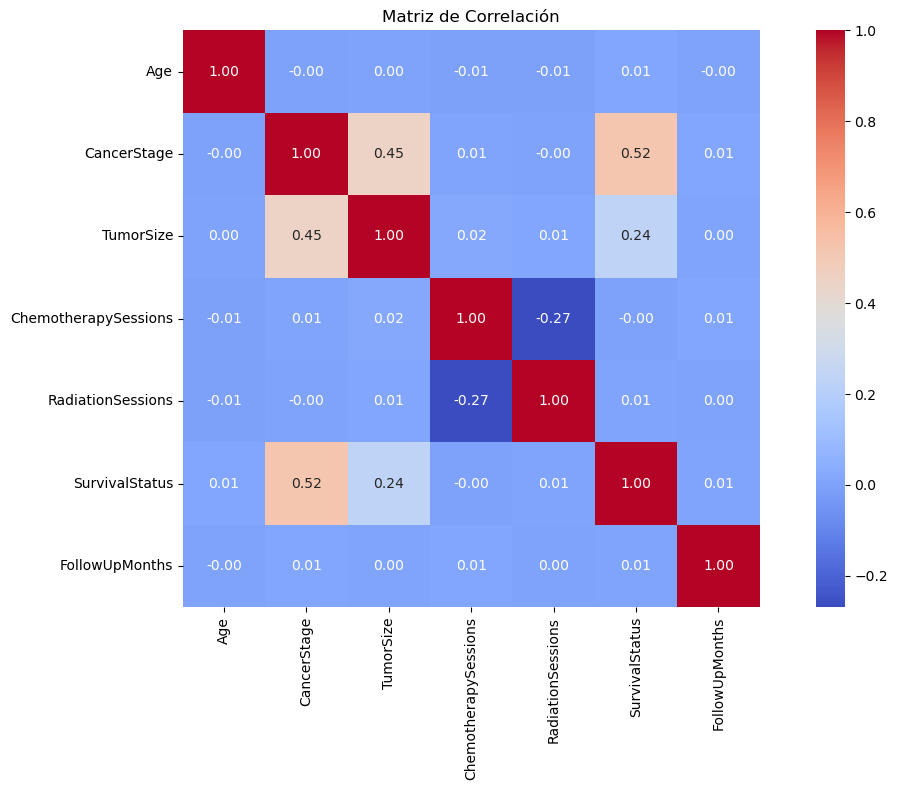

In [33]:
# Seleccionar solo columnas numéricas
df_numeric = df.select_dtypes(include='number')

# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Visualizar con heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()


CancerStage y TumorSize: 0.45

Tumores más grandes suelen estar en etapas más avanzadas.

In [34]:
# Correlación de cada columna con el target
target_corr = corr_matrix["SurvivalStatus"].sort_values()

# Mostrar las menos correlacionadas con el target
print("📉 Variables menos correlacionadas con SurvivalStatus:")
print(target_corr[abs(target_corr) < 0.1])

📉 Variables menos correlacionadas con SurvivalStatus:
ChemotherapySessions   -0.003333
RadiationSessions       0.006848
FollowUpMonths          0.007619
Age                     0.011736
Name: SurvivalStatus, dtype: float64


In [35]:
df_ml = df.copy()

#Eliminar columnas no predictivas
df_ml.drop(['PatientID', 'DiagnosisDate', 'SurgeryDate'], axis=1, inplace=True)

#Separar X e y
X = df_ml.drop('SurvivalStatus', axis=1)
y = df_ml['SurvivalStatus']

#Codificar variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Mostrar la forma final
print("X shape:", X_encoded.shape)
print("y shape:", y.shape)


X shape: (10000, 51)
y shape: (10000,)


In [36]:
#Verificamos qué columnas son categóricas
cat_cols = X.select_dtypes(include='object').columns.tolist()
print("Columnas categóricas:", cat_cols)

Columnas categóricas: ['Gender', 'Province', 'Ethnicity', 'TumorType', 'Metastasis', 'TreatmentType', 'SmokingStatus', 'AlcoholUse', 'GeneticMutation', 'Comorbidities']


In [37]:
#Dividir antes de escalar
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

#Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

XgBoost

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier

def optimizar_xgboost(X, y):
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0]
    }

    scorer = make_scorer(f1_score, pos_label=1)

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=scorer,
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X, y)

    print("✅ Mejores parámetros encontrados:")
    print(grid_search.best_params_)
    print("\n📈 Mejor F1-Score obtenido:")
    print(grid_search.best_score_)

    return grid_search.best_estimator_


In [39]:
modelo_xgb_optimo = optimizar_xgboost(X_train_scaled, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
✅ Mejores parámetros encontrados:
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

📈 Mejor F1-Score obtenido:
0.5110399980382078


p:\ironhack\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:16:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [40]:
y_pred = modelo_xgb_optimo.predict(X_test_scaled)

print("🔍 Classification Report")
print(classification_report(y_test, y_pred))

print("📊 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))


🔍 Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1558
           1       0.51      0.48      0.49       442

    accuracy                           0.78      2000
   macro avg       0.68      0.67      0.68      2000
weighted avg       0.78      0.78      0.78      2000

📊 Confusion Matrix
[[1351  207]
 [ 229  213]]


KNN

In [41]:

#Inicializar el modelo KNN (k=5 por defecto)
knn = KNeighborsClassifier()

#Entrenar con datos escalados
knn.fit(X_train_scaled, y_train)

#Predecir en datos de prueba escalados
y_pred = knn.predict(X_test_scaled)

#Evaluar resultados
print("🔎 Accuracy:", accuracy_score(y_test, y_pred))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


🔎 Accuracy: 0.7625

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1558
           1       0.43      0.21      0.29       442

    accuracy                           0.76      2000
   macro avg       0.62      0.57      0.57      2000
weighted avg       0.72      0.76      0.73      2000


🧱 Confusion Matrix:
[[1430  128]
 [ 347   95]]


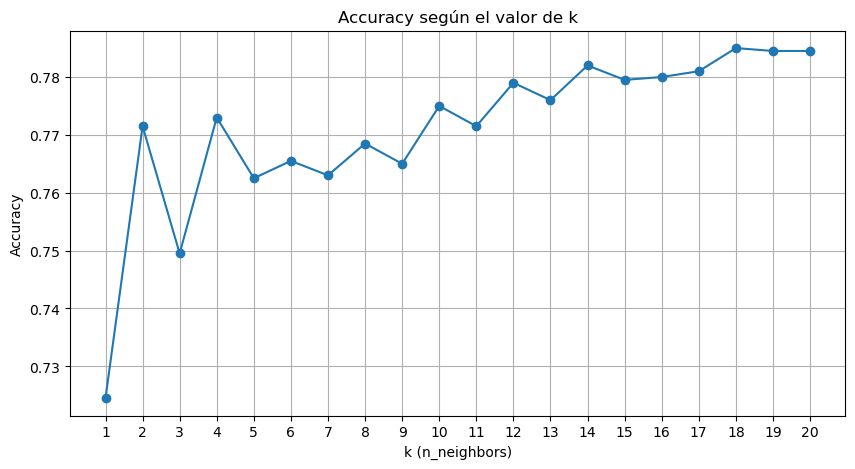

In [42]:
# Probar k de 1 a 20
k_values = range(1, 21)
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    y_pred_k = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

# Mostrar gráfico
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o')
plt.title("Accuracy según el valor de k")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.show()


Vemos que en k=18 tenemos el mayor nivel de Accuracy

In [43]:
# Reentrenar con k = 18
knn_13 = KNeighborsClassifier(n_neighbors=18)
knn_13.fit(X_train_scaled, y_train)

# Predecir y evaluar
y_pred_13 = knn_13.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Resultados
print("🔎 Accuracy (k=18):", accuracy_score(y_test, y_pred_13))

print("\n📋 Classification Report (k=18):")
print(classification_report(y_test, y_pred_13))

print("\n🧱 Confusion Matrix (k=18):")
print(confusion_matrix(y_test, y_pred_13))


🔎 Accuracy (k=18): 0.785

📋 Classification Report (k=18):
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1558
           1       0.64      0.06      0.12       442

    accuracy                           0.79      2000
   macro avg       0.71      0.53      0.50      2000
weighted avg       0.75      0.79      0.71      2000


🧱 Confusion Matrix (k=18):
[[1542   16]
 [ 414   28]]


In [45]:
# 1️⃣ Definir el grid de hiperparámetros a probar
param_grid = {
    'n_neighbors': list(range(1, 31)),                # Prueba k de 1 a 30
    'weights': ['uniform', 'distance'],               # Pesos iguales o inversos a la distancia
    'metric': ['euclidean', 'manhattan']              # Distancia Euclídea o Manhattan
}

# 2️⃣ Crear el objeto GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,       # Usa todos los núcleos disponibles
    verbose=1
)

# 3️⃣ Entrenar con el conjunto de entrenamiento escalado
grid_search.fit(X_train_scaled, y_train)

# 4️⃣ Mostrar los mejores parámetros encontrados
print("🔍 Mejor combinación de parámetros:")
print(grid_search.best_params_)

# 5️⃣ Evaluar el mejor modelo en el conjunto de test
best_knn = grid_search.best_estimator_
y_pred_grid = best_knn.predict(X_test_scaled)

# 6️⃣ Reporte final
print("\n📊 Accuracy en test:", accuracy_score(y_test, y_pred_grid))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_grid))
print("\n🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_grid))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
🔍 Mejor combinación de parámetros:
{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}

📊 Accuracy en test: 0.7785

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1558
           1       0.50      0.12      0.20       442

    accuracy                           0.78      2000
   macro avg       0.65      0.54      0.54      2000
weighted avg       0.73      0.78      0.72      2000


🧱 Confusion Matrix:
[[1502   56]
 [ 387   55]]


Random Forest

In [46]:
rf = RandomForestClassifier(
    n_estimators=100,          # Número de árboles
    max_depth=None,            # Profundidad máxima (None = sin límite)
    random_state=42,           # Para reproducibilidad
    class_weight='balanced'    # 🔥 Muy importante para datos desbalanceados
)

rf.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [47]:
y_pred_rf = rf.predict(X_test_scaled)

print("🌲 Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\n🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


🌲 Accuracy (Random Forest): 0.7755

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1558
           1       0.49      0.33      0.39       442

    accuracy                           0.78      2000
   macro avg       0.66      0.62      0.63      2000
weighted avg       0.75      0.78      0.76      2000


🧱 Confusion Matrix:
[[1405  153]
 [ 296  146]]


Gradient Boosting

In [48]:
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)

print("🌄 Accuracy (Gradient Boosting):", accuracy_score(y_test, y_pred_gb))
print("\n📋 Classification Report (GB):")
print(classification_report(y_test, y_pred_gb))
print("\n🧱 Confusion Matrix (GB):")
print(confusion_matrix(y_test, y_pred_gb))


🌄 Accuracy (Gradient Boosting): 0.767

📋 Classification Report (GB):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1558
           1       0.47      0.46      0.47       442

    accuracy                           0.77      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.76      0.77      0.77      2000


🧱 Confusion Matrix (GB):
[[1331  227]
 [ 239  203]]


Adaptative Boosting

In [49]:
ab = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

ab.fit(X_train_scaled, y_train)
y_pred_ab = ab.predict(X_test_scaled)

print("⚡ Accuracy (AdaBoost):", accuracy_score(y_test, y_pred_ab))
print("\n📋 Classification Report (AdaBoost):")
print(classification_report(y_test, y_pred_ab))
print("\n🧱 Confusion Matrix (AdaBoost):")
print(confusion_matrix(y_test, y_pred_ab))


p:\ironhack\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


⚡ Accuracy (AdaBoost): 0.7665

📋 Classification Report (AdaBoost):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1558
           1       0.47      0.46      0.46       442

    accuracy                           0.77      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.76      0.77      0.77      2000


🧱 Confusion Matrix (AdaBoost):
[[1331  227]
 [ 240  202]]


Logistic Regression

In [50]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print("📊 LOGISTIC REGRESSION")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

📊 LOGISTIC REGRESSION
Accuracy: 0.765
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1558
           1       0.46      0.35      0.40       442

    accuracy                           0.77      2000
   macro avg       0.64      0.62      0.63      2000
weighted avg       0.75      0.77      0.75      2000

Confusion Matrix:
 [[1375  183]
 [ 287  155]]


Tabla comparativa

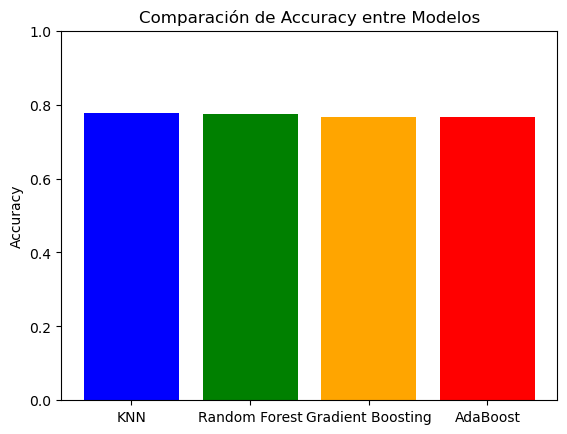

In [51]:
models = ['KNN', 'Random Forest', 'Gradient Boosting', 'AdaBoost']
accuracies = [
    accuracy_score(y_test, y_pred_grid),   # mejor KNN
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_gb),
    accuracy_score(y_test, y_pred_ab)
]

plt.bar(models, accuracies, color=["blue", "green", "orange", "red"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparación de Accuracy entre Modelos")
plt.show()


In [ ]:
# Reordenar esto
# Aplicamos SMOTE al set de entrenamiento
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Entrenamos el mejor modelo (AdaBoost) con los datos balanceados
modelo_ada_smote = AdaBoostClassifier(n_estimators=100, random_state=42)
modelo_ada_smote.fit(X_resampled, y_resampled)

# Guardamos el modelo entrenado
joblib.dump(modelo_ada_smote, "modelo_adaboost_smote.pkl")


p:\ironhack\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


['modelo_adaboost_smote.pkl']